In [ ]:
!pip install plotly tfa-nightly tqdm numpy matplotlib

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Subtract, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import tensorflow_addons as tfa
from tqdm.notebook import tqdm


In [ ]:
plt.rcParams['figure.figsize'] = (9, 5)

In [ ]:
noise_std_train = (0, 55)
noise_std_val = 30
batch_size = 32
im_size = 128


def generate_vertical_bands_images(im_size=128, prop_bands=0.2):
    while True:
        im = np.zeros((im_size, im_size), dtype=np.float64)
        band_locations = np.random.randint(0, im_size, int(prop_bands * im_size))
        im[:, band_locations] = 1.0
        yield im

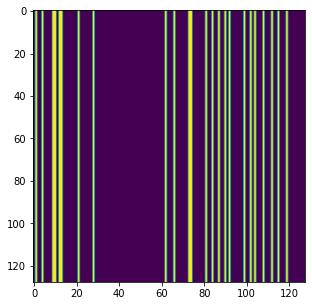

In [ ]:
plt.figure()
plt.imshow(next(generate_vertical_bands_images()))

In [ ]:
vert_ds = tf.data.Dataset.from_generator(
    generate_vertical_bands_images, 
    tf.float32, 
    tf.TensorShape([im_size, im_size]),
    args=(im_size, 0.2)
).map(lambda x: x[..., None], num_parallel_calls=tf.data.experimental.AUTOTUNE)

def add_noise_function(noise_std_range):
    if not isinstance(noise_std_range, tuple):
        noise_std_range = (noise_std_range, noise_std_range)
    def add_noise(image):
        noise_std = tf.random.uniform(
            (1,),
            minval=noise_std_range[0],
            maxval=noise_std_range[1],
        )
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_std/255, dtype=tf.float32)
        return image + noise
    return add_noise

add_noise_train = add_noise_function(noise_std_train)
add_noise_val = add_noise_function(noise_std_val)

vert_ds_train = vert_ds.map(
    lambda patch: (add_noise_train(patch), patch),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
).batch(batch_size).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

vert_ds_val = vert_ds.map(
    lambda patch: (add_noise_val(patch), patch),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
).batch(batch_size).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

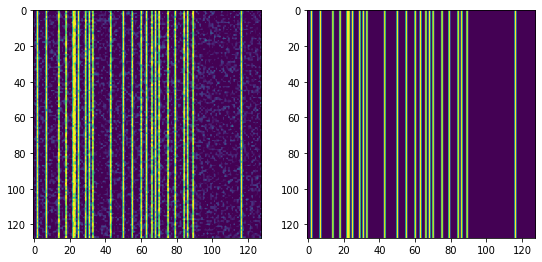

In [ ]:
fig, axs = plt.subplots(1, 2)
training_example = next(iter(vert_ds_train))
axs[0].imshow(np.squeeze(training_example[0][0]), vmin=0, vmax=1)
axs[1].imshow(np.squeeze(training_example[1][0]), vmin=0, vmax=1)

In [ ]:
class SingularValuesConstraint(tf.keras.constraints.Constraint):
  """Hard thresholding of singular values"""

  def __init__(self, thr_value = 0.3, axis = 0, ff_size = 25, n_filters = 16):
    self.thr_value = thr_value
    self.axis = axis
    self.ff_size = ff_size
    self.n_filters = n_filters

  def __call__(self, w):
    w_reshaped = tf.reshape(w, [-1, self.ff_size, self.n_filters])
    s, u, v = tf.linalg.svd(w_reshaped)
    thr = self.thr_value*s[0]
    s=tf.where(s < thr, 0.0, s)
    w_reshaped=tf.matmul(u,tf.matmul(tf.linalg.diag(s),v,adjoint_b=True))
    w = tf.reshape(w_reshaped, [5, 5, 1, 16])
    return w

  def get_config(self):
    return {'thr_value': self.thr_value, 'axis': self.axis}


In [ ]:
tf.keras.initializers.GlorotUniform(seed=None)

class LinearFiltersCombine(Model):
  def __init__(self, n_filters=1, drop_rate=0., **kwargs):
    super(LinearFiltersCombine, self).__init__(**kwargs)
    constraint = SingularValuesConstraint(thr_value=0.5, axis=[0, 1, 2])
    initializer = tf.keras.initializers.Constant(1/25)
    self.decomposition = Conv2D(
      n_filters,
      5,
      padding='valid',
      activation='linear',
      kernel_initializer=initializer,
      kernel_constraint=constraint,
      use_bias=False,
    )
    self.drop = Dropout(drop_rate, noise_shape=(batch_size, 1, 1, n_filters)) # omits certain neurons
    self.linear_combination = Conv2D(1, 1, use_bias=True)
    self.paddings = tf.constant([(0,0), (2, 2), (2, 2), (0, 0)])
  
  def call(self, inputs):
    im_padded = tf.pad(inputs, self.paddings, 'SYMMETRIC')
    im_conv = self.decomposition(im_padded)
    im_drop = self.drop(im_conv)
    res = self.linear_combination(im_drop)
    return res

base_f = 4
model = LinearFiltersCombine(n_filters=base_f**2, drop_rate=0.)
# model.build()

def tf_psnr(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, 1.0)

def tf_ssim(y_true, y_pred):
  return tf.image.ssim(y_true, y_pred, 1.0)

model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=[tf_psnr, tf_ssim])

In [ ]:
model(tf.zeros([1, 32, 32, 1])).shape

TensorShape([1, 32, 32, 1])

In [ ]:
tqdm_cb = tfa.callbacks.TQDMProgressBar(metrics_format="{name}: {value:e}")
tqdm_cb.tqdm = tqdm

In [ ]:
model.fit(
    vert_ds_train, 
    steps_per_epoch=200, 
    epochs=15,
    validation_data=vert_ds_val,
    validation_steps=1,
    verbose=0,
    callbacks=[tqdm_cb,],
    shuffle=False,
)

Epoch 1/15



Epoch 2/15



Epoch 3/15



Epoch 4/15



Epoch 5/15



Epoch 6/15



Epoch 7/15



Epoch 8/15



Epoch 9/15



Epoch 10/15



Epoch 11/15



Epoch 12/15



Epoch 13/15



Epoch 14/15



Epoch 15/15


In [ ]:
metrics = model.evaluate(vert_ds_val, steps=300)

300/300 [==============================] - 5s 18ms/step - loss: 0.0028 - tf_psnr: 25.5751 - tf_ssim: 0.8018


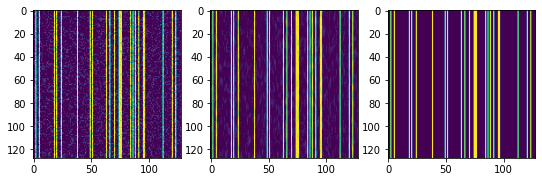

In [ ]:
example_val = next(iter(vert_ds_val))
denoised_image = model.predict_on_batch(example_val[0])

fig, axs = plt.subplots(1, 3)
axs[0].imshow(np.squeeze(example_val[0][0]), vmin=0, vmax=1)
axs[1].imshow(np.squeeze(denoised_image[0]), vmin=0, vmax=1)
axs[2].imshow(np.squeeze(example_val[1][0]), vmin=0, vmax=1)

## Filters visualization

In [ ]:
decomp_kernels = model.layers[0].get_weights()[0]
recomb_kernels = model.layers[2].get_weights()[0]


(array([ 2.3527335e-01,  8.1612852e-05, -2.0530495e-05,  2.4659224e-05,
        7.2486073e-06], dtype=float32), array([[-0.4473962 ,  0.3974826 , -0.7171294 , -0.4984477 , -0.42661926],
       [-0.44689834, -0.5959823 ,  0.3159728 ,  0.6030252 , -0.558316  ],
       [-0.4473531 ,  0.23634985,  0.00978936, -0.04909331, -0.00477813],
       [-0.44696575, -0.56493   , -0.20356426,  0.43156928,  0.41717672],
       [-0.44745427,  0.3343733 ,  0.5868155 , -0.4463724 ,  0.57638526]],
      dtype=float32))
(array([ 1.6399789e-01, -9.9490360e-05,  1.8977604e-05, -2.2936747e-05,
       -5.8052615e-06], dtype=float32), array([[-0.44697046, -0.46525913, -0.7271477 ,  0.48707676, -0.47729692],
       [-0.44763672,  0.5176627 ,  0.31494844, -0.6078418 , -0.519935  ],
       [-0.44702807, -0.32692453,  0.01168057,  0.05007097, -0.00320807],
       [-0.44754317,  0.45547375, -0.17419587, -0.38244072,  0.45346105],
       [-0.44688898, -0.44857913,  0.5844511 ,  0.49448615,  0.5442592 ]],
      dtype=

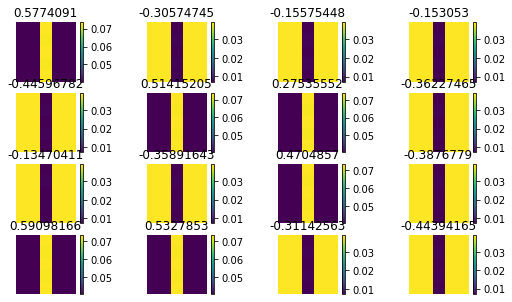

In [ ]:
fig, axs = plt.subplots(base_f, base_f, sharex=True, sharey=True)
for i in range(base_f):
  for j in range(base_f):
    im = axs[i, j].imshow(np.squeeze(decomp_kernels[..., 0, i * base_f + j]))
    axs[i, j].axis('off')
    axs[i, j].set_title(np.squeeze(recomb_kernels[..., i * base_f + j, 0]))
    fig.colorbar(im, ax=axs[i, j])
    print(np.linalg.eig(decomp_kernels[..., 0, i * base_f + j]))

    

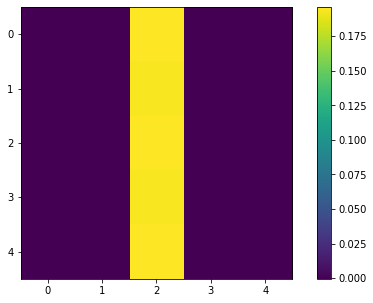

In [ ]:

plt.figure()
plt.imshow(np.squeeze(np.dot(decomp_kernels[:, :, 0], np.squeeze(recomb_kernels))))
plt.colorbar()

In [ ]:
np.dot(decomp_kernels[:, :, 0], np.squeeze(recomb_kernels))

array([[-1.2951670e-04, -1.6088411e-04,  1.9603786e-01, -3.9923470e-04,
         7.1902759e-06],
       [-8.9131296e-05, -1.5940564e-04,  1.9442025e-01, -2.6469538e-04,
        -8.0563594e-05],
       [-1.3869861e-04, -2.1224516e-04,  1.9597699e-01, -3.0557020e-04,
        -9.5148571e-05],
       [-7.1319286e-05, -1.1848984e-04,  1.9445366e-01, -2.4620537e-04,
         2.6064459e-05],
       [-2.8640032e-05, -2.2817962e-04,  1.9606358e-01, -2.2507692e-04,
        -4.3390319e-05]], dtype=float32)

## Fixed filter

In [ ]:
class FixedFilter(Model):
  def __init__(self, **kwargs):
    super(FixedFilter, self).__init__(**kwargs)
    self.weight = tf.constant([
      [0, 0, 1/5, 0, 0],
      [0, 0, 1/5, 0, 0],
      [0, 0, 1/5, 0, 0],
      [0, 0, 1/5, 0, 0],
      [0, 0, 1/5, 0, 0],
    ])[..., None, None]
    self.paddings = tf.constant([(0,0), (2, 2), (2, 2), (0, 0)])

  def call(self, inputs):
    im_padded = tf.pad(inputs, self.paddings, 'SYMMETRIC')
    im_conv = tf.nn.conv2d(im_padded, self.weight, 1, 'VALID')
    # res = inputs - im_conv
    res = im_conv
    return res

model_2 = FixedFilter()
model_2.compile(loss='mse', metrics=[tf_psnr, tf_ssim])

In [ ]:
metrics = model_2.evaluate(vert_ds_val, steps=300)

300/300 [==============================] - 6s 17ms/step - loss: 0.0028 - tf_psnr: 25.4982 - tf_ssim: 0.7942


In [ ]:
def SingularValues(kernel, input_size):
    #transform = tf.signal.fft2d(kernel, input_size)

    s, u, v = tf.linalg.svd(kernel)
    s_n = s.numpy()
    thr = 0.5*s_n[0]
    return u*tf.convert_to_tensor(np.where(s < thr, 0, s))*tf.transpose(v)

print(SingularValues(decomp_kernels[:,:, 0, 0], 128))
print(SingularValues(tf.constant([
      [0, 0, 1/5, 0, 0],
      [0, 0, 1/5, 0, 0],
      [0, 0, 1/5, 0, 0],
      [0, 0, 1/5, 0, 0],
      [0, 0, 1/5, 0, 0],
    ]), 128))

tf.Tensor(
[[ 0.04052084 -0.          0.          0.          0.        ]
 [ 0.03503367  0.          0.         -0.          0.        ]
 [-0.02903249 -0.          0.          0.         -0.        ]
 [ 0.0413525  -0.         -0.         -0.         -0.        ]
 [ 0.08073465 -0.          0.         -0.         -0.        ]], shape=(5, 5), dtype=float32)
tf.Tensor(
[[-0.         -0.         -0.          0.          0.        ]
 [ 0.19999999 -0.         -0.          0.          0.        ]
 [-0.         -0.          0.         -0.         -0.        ]
 [-0.          0.         -0.          0.         -0.        ]
 [-0.          0.         -0.         -0.          0.        ]], shape=(5, 5), dtype=float32)
